<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/Hyperparameters_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подгружаем необходимые библиотеки 

In [ ]:
pip install pytorch-tabnet

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

from hyperopt import hp
import numpy as np

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time
import joblib

In [ ]:
import torch

#Загружаем данные, параметры

In [ ]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [ ]:
#df = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/df_agg.pkl')#pd.read_csv('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/df_agg.csv')
#agr_feature = [x for x in df.columns if x not in feature_columns]

In [ ]:
def data_preparation(X, y, c=10000, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = c
    count1 = c

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

In [ ]:
def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     1000
}
lgb_fit_params = {
    'early_stopping_rounds': 50,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

tabnet_reg_params = {
    'n_d' :              8,
    'n_a' :              8,
    'n_shared':          hp.randint('n_shared', 3)+1,
    'n_independent':     hp.randint('n_independent', 3)+1,
    'n_steps' :          hp.randint('n_steps', 3)+3,
    'gamma' :            hp.uniform('gamma', 1.0, 3.0),
    'lambda_sparse' :    hp.uniform('lambda_sparse', 0.0, 0.01),
    'optimizer_params' : dict(lr=2e-2),
    'scheduler_params' : {"step_size":200, "gamma":0.95},
    'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
    'mask_type' :       'entmax'
}

tabnet_fit_params = {
    'max_epochs' : 2000, 
    'patience' : 20,
    'batch_size' : 1024,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}
tabnet_para = dict()
tabnet_para['reg_params'] = tabnet_reg_params
tabnet_para['fit_params'] = tabnet_fit_params
tabnet_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [ ]:
class HPOpt(object):

    def __init__(self, X, y, cv=3):
        self.X = X
        self.y = y
        self.cv = cv
        #print('init')

    def process(self, fn_name, space, trials, algo, max_evals):
        #print('in process')
        fn = getattr(self, fn_name)
        try:
            #print('try')
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
            #print('i can')
        except Exception as e:
            print({'status': STATUS_FAIL,
                    'exception': str(e)})
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = RandomForestClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        if self.cv>1:
          return self.train_cv_gb(reg, para)
        return self.train_reg(reg, para)

    def tabnet_reg(self, para):
        #print('class')
        reg = TabNetClassifier(**para['reg_params'])
        #print('end class')
        if self.cv>1:
          return self.train_cv_tn(reg, para)
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        if len(para['fit_params'])>0:
            #print('start')
            reg.fit(self.X, self.y,
                  eval_set=[(self.X, self.y), (self.X, self.y)],
                  **para['fit_params'])
        else:
            reg.fit(self.X, self.y)
        pred = reg.predict(self.X)
        loss = para['score'](self.y, pred)
        return {'loss': loss, 'status': STATUS_OK}

    def train_cv_tn(self, reg, para):
        kf = KFold(n_splits=self.cv, shuffle=False)
        loss = 0 
        for train, test in kf.split(self.X):
            #print('start', type(train[0]), type(test[0]), type(self.y[0]), type(self.X))
            if len(para['fit_params'])>0:
                reg = TabNetClassifier(**para['reg_params'])
                reg.fit(self.X[train], self.y[train],
                      eval_set=[(self.X[train], self.y[train]), (self.X[test], self.y[test])],
                      **para['fit_params'])
            else:
                reg.fit(self.X[train], self.y[train])
            #print('pred')
            pred = reg.predict(self.X[test])
            score = para['score'](self.y[test], pred)
            loss += score

        loss=loss/self.cv
        return {'loss': loss, 'status': STATUS_OK}

    def train_cv_gb(self, reg, para):
        kf = KFold(n_splits=self.cv, shuffle=False)
        loss = 0 
        for train, test in kf.split(self.X):
            #print('start', type(train[0]), type(test[0]), type(self.y[0]), type(self.X))
            if len(para['fit_params'])>0:
                reg = lgb.LGBMClassifier(**para['reg_params'])
                reg.fit(self.X[train], self.y[train],
                      eval_set=[(self.X[train], self.y[train]), (self.X[test], self.y[test])],
                      **para['fit_params'])
            else:
                reg.fit(self.X[train], self.y[train])
            #print('pred')
            pred = reg.predict(self.X[test])
            score = para['score'](self.y[test], pred)
            loss += score

        loss=loss/self.cv
        return {'loss': loss, 'status': STATUS_OK}


In [ ]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [ ]:
X, y  = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/X_y.pkl')

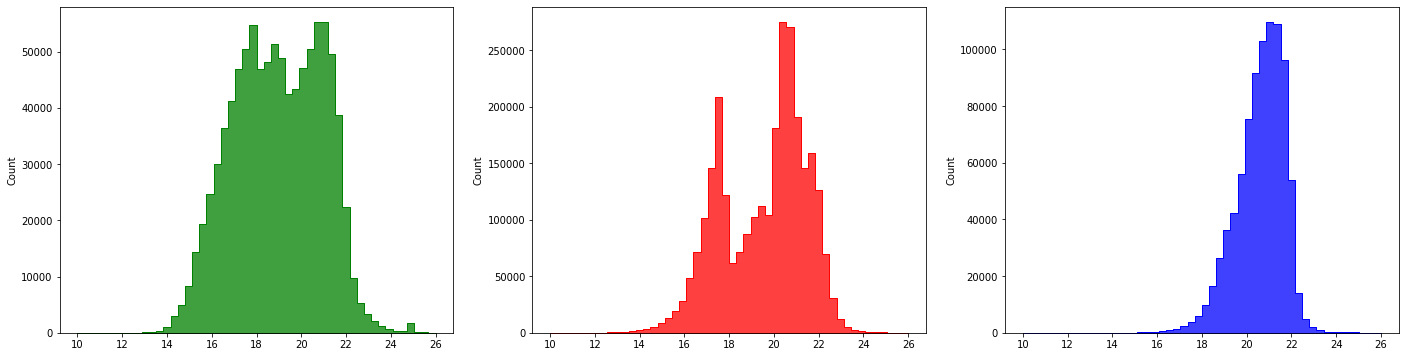

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X[y==1][:, 7], ax = ax1, bins = 50, color = 'g', element="step", binrange=(10, 26))
sns.histplot(X[y==2][:, 7], ax = ax2, bins = 50, color = 'r', element="step", binrange=(10, 26))
sns.histplot(X[y==3][:, 7], ax = ax3, bins = 50, color = 'b', element="step", binrange=(10, 26))

# Общая функция

In [ ]:
#dftn_time = pd.DataFrame(columns = ['Rows', 'train', 'test', 'Nd',	'Na',	'B',	'BV',	'mB',	'λsparse',	'Nsteps',	'γ',	'learning rate',	'decay rate',	'decay iterations', 'shared', 	'decision',	'mask_type',	'accuracy_tn', 'time_learn_tn',	'time_tn',	'accuracy_gb', 'time_learn_gb',	'time_gb'])

In [ ]:
dftn_time = pd.read_csv('/content/drive/MyDrive/Научная работа/Data/hyper/cpu_time.csv')

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869
7,30000,30000,30000,64,64,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.891433,2433.883205,201.544638,0.894200,1.618982e+09,20.734107
8,30000,30000,30000,32,32,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.894833,814.815927,103.367213,0.893500,1.618983e+09,20.529149
9,30000,30000,30000,128,128,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.894367,5522.418471,288.120832,0.894933,1.618989e+09,22.549996


##Старые

In [ ]:
with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'w') as f:
  pass

In [ ]:
def bootstrap_accuracy(model, X_test, y_test):
  from sklearn.utils import resample
  from matplotlib import pyplot
  values = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
  n_iterations = 100
  n_size = int(len(y_test) * 0.50)
  stats = list()
  for i in range(n_iterations):
    test = resample(values, n_samples=n_size)
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    stats.append(score)
  #pyplot.hist(stats, range=(0.872, 0.9))
  #pyplot.show()
  alpha = 0.97
  p = ((1.0-alpha)/2.0) * 100
  lower = max(0.0, np.percentile(stats, p))
  p = (alpha+((1.0-alpha)/2.0)) * 100
  upper = min(1.0, np.percentile(stats, p))
  main = np.mean(stats)
  #print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
  return main, np.max([main-lower, upper-main])

In [ ]:
def bootstrap(X_test, y_test, X_valid, y_valid):
  from sklearn.utils import resample
  from matplotlib import pyplot
  values = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
  n_iterations = 100
  n_size = int(len(y_test) * 0.50)
  stats = list()
  for i in range(n_iterations):
    train_ind = np.random.randint(0, len(values), n_size)
    test_ind = np.setdiff1d(range(len(values)), train_ind)
    train = values[train_ind]
    test = values[test_ind]
    # fit model
    model = lgb.LGBMClassifier()
    model.fit(train[:,:-1], train[:,-1], eval_set=[(train[:,:-1], train[:,-1]), (X_valid, y_valid)], **lgb_fit_params)
    # evaluate model
    predictions = model.predict(test[:,:-1])
    test = resample(values, n_samples=n_size)
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    stats.append(score)
  alpha = 0.97
  p = ((1.0-alpha)/2.0) * 100
  lower = max(0.0, np.percentile(stats, p))
  p = (alpha+((1.0-alpha)/2.0)) * 100
  upper = min(1.0, np.percentile(stats, p))
  main = np.mean(stats)
  #print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
  return main, np.max([main-lower, upper-main])

In [ ]:
def feature_acc(model, str_m, Rows):
  print(str_m)

  feature_imp=pd.DataFrame((zip(model.feature_importances_, photo_columns+agr_feature)), columns=['Model','Feature'])
  t = 3
  feature = feature_imp.sort_values(by='Model', ascending=False).iloc[:t]['Feature'].values
  X = df[feature].values

  data_split = data_preparation(X, y, Rows, 0.8)
  count = Rows//3

  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]
  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)

  X_train, y_train = train[:,:-1], train[:,-1].astype('int')
  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  X_valid   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
  y_valid   = np.concatenate((y1_test[count : 2*count], y2_test[count : 2*count], y3_test[count : 2*count]))

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  X_valid_norm = robust.transform(X_valid)

  acc, err = bootstrap(X_test_norm, y_test, X_valid_norm, y_valid)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('acc_feature '+str_m+': '+str(acc)+'+-'+str(err)+', ')

In [ ]:
def ones(number_exp, Rows, Nd,	Na,	B,	BV,	mB,	λsparse,	Nsteps,	γ, learning_rate,	decay_rate,	decay_iterations,	shared, decision, mask_type):
  
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('number: '+str(number_exp)+', ')
  
  #data
  data_split = data_preparation(X, y, c=Rows//3)

  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]

  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)
  X_train, y_train = train[:,:-1], train[:,-1].astype('int')

  count = Rows//3

  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  X_train_pred = np.concatenate((X1_test[2*count : 4*count], X2_test[2*count : 4*count], X3_test[2*count : 4*count])) ###############
  X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
  np.random.shuffle(X_train_pred)
  np.random.shuffle(X_val_pred)

  X_valid      = np.concatenate((X1_test[4*count : 5*count], X2_test[4*count : 5*count], X3_test[4*count : 5*count]))
  y_valid      = np.concatenate((y1_test[4*count : 5*count], y2_test[4*count : 5*count], y3_test[4*count : 5*count]))

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  X_valid_norm = robust.transform(X_valid)


  #classifier
  tn = TabNetClassifier( n_d=Nd, n_a=Na,
                          n_shared=shared, n_independent=decision,
                          momentum=mB,
                          optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=learning_rate),
                          scheduler_params={"step_size":decay_iterations, # how to use learning rate scheduler
                                            "gamma":decay_rate},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,

                          mask_type=mask_type,
                          **{ 'gamma': γ,
                              'lambda_sparse':λsparse,
                              'n_steps': Nsteps}

  )

  max_epochs = 2000

  patience=50
  t = time()
  tn.fit(
      X_train=X_train, y_train=y_train,
      #X_valid=X_valid, y_valid=y_valid,
      eval_set=[(X_train, y_train), (X_test, y_test)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss','accuracy'],
      max_epochs=max_epochs , patience=patience,
      batch_size=B, virtual_batch_size=BV,
  ) 
  t = time()-t
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('time TN: '+str(t)+', ')

  gb = lgb.LGBMClassifier(  #ЛУЧШАЯ МОДЕЛЬ
    **{'learning_rate': 0.0741521019613115,
    'min_child_samples': 9+1,
    'min_child_weight': 0.43858057836890685,
    'n_estimators': 1000,
    'num_leaves': 59+10}
  )

  t = time()
  gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)
  t = time()-t
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('time GB: '+str(t)+', ')

  #Accuracy
  acc, err = bootstrap_accuracy(tn, X_test, y_test)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('acc TN: '+str(acc)+'+-'+str(err)+', ')
  acc, err = bootstrap_accuracy(gb, X_test_norm, y_test)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('acc GB: '+str(acc)+'+-'+str(err)+', ')

  #Feature importance
  feature_acc(tn, 'TN', 9000)
  feature_acc(gb, 'GB', 9000)

  #save model

  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('\n')
  gb.booster_.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/gb'+str(number_exp)+'.txt')
  tn.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/tn'+str(number_exp))

In [ ]:
def memory(number_exp, Rows, Nd,	Na,	B,	BV,	mB,	λsparse,	Nsteps,	γ, learning_rate,	decay_rate,	decay_iterations,	shared, decision, mask_type):
  
  #data
  data_split = data_preparation(X, y, c=Rows//3, test_size=0.5)

  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]

  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)
  X_train, y_train = train[:,:-1], train[:,-1].astype('int')

  count = Rows//3

  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  np.random.shuffle(X_train_pred)
  np.random.shuffle(X_val_pred)

  #X_valid      = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
  #y_valid      = np.concatenate((y1_test[count : 2*count], y2_test[count : 2*count], y3_test[count : 2*count]))

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  #X_valid_norm = robust.transform(X_valid)


  #classifier
  tn = TabNetClassifier( n_d=Nd, n_a=Na,
                          n_shared=shared, n_independent=decision,
                          momentum=mB,
                          optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=learning_rate),
                          scheduler_params={"step_size":decay_iterations, # how to use learning rate scheduler
                                            "gamma":decay_rate},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,

                          mask_type=mask_type,
                          **{ 'gamma': γ,
                              'lambda_sparse':λsparse,
                              'n_steps': Nsteps}

  )

  max_epochs = 2000

  patience=50
  t = time()
  tn.fit(
      X_train=X_train, y_train=y_train,
      #X_valid=X_valid, y_valid=y_valid,
      eval_set=[(X_train, y_train), (X_test, y_test)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss','accuracy'],
      max_epochs=max_epochs , patience=patience,
      batch_size=B, virtual_batch_size=BV,
  ) 
  t = time()-t
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('time TN: '+str(t)+', ')

  gb = lgb.LGBMClassifier(  #ЛУЧШАЯ МОДЕЛЬ
    **{'learning_rate': 0.0741521019613115,
    'min_child_samples': 9+1,
    'min_child_weight': 0.43858057836890685,
    'n_estimators': 1000,
    'num_leaves': 59+10}
  )

  t = time()
  gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],  **lgb_fit_params)
  t = time()-t
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('time GB: '+str(t)+', ')

  #save model

  joblib.dump(gb, '/content/drive/MyDrive/Научная работа/Data/hyper/gb'+str(number_exp)+'.pkl')
  joblib.dump(tn, '/content/drive/MyDrive/Научная работа/Data/hyper/tn'+str(number_exp)+'.pkl')


##Новая

In [ ]:
X_main_test = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/X_main_test.pkl')
y_main_test = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/y_main_test.pkl')

In [ ]:
def time_model(number_exp, Rows, Nd,	Na,	B,	BV,	mB,	λsparse,	Nsteps,	γ, learning_rate,	decay_rate,	decay_iterations,	shared, decision, mask_type, gb_do=False):

  global dftn_time
  global X_main_test 
  global y_main_test

  data = {'Rows':Rows, 'Nd':Nd,	'Na':Na,	'B':B,	'BV':BV,	'mB':mB,	'λsparse':λsparse,	'Nsteps':Nsteps,	'γ':γ,	'learning rate':learning_rate,	'decay rate':decay_rate,	'decay iterations':decay_iterations,	'shared':shared, 	'decision':decision,	'mask_type':mask_type}
  'accuracy_tn', 'time_learn_tn',	'time_tn',	'accuracy_gb', 'time_learn_tn',	'time_gb'
  data_split = data_preparation(X, y, c=Rows//3, test_size=0.5)

  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]

  data['train'] = len(y_train)
  data['test'] = len(y_test)

  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)
  X_train, y_train = train[:,:-1], train[:,-1].astype('int')

  count = Rows//3

  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  X_valid = X_test
  y_valid = y_test

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  X_main_test_norm = robust.transform(X_main_test)
  X_valid_norm = X_test_norm


  #classifier
  tn = TabNetClassifier( n_d=Nd, n_a=Na,
                          n_shared=shared, n_independent=decision,
                          momentum=mB,
                          optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=learning_rate),
                          scheduler_params={"step_size":decay_iterations, # how to use learning rate scheduler
                                            "gamma":decay_rate},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,

                          mask_type=mask_type,
                          **{ 'gamma': γ,
                              'lambda_sparse':λsparse,
                              'n_steps': Nsteps}

  )

  max_epochs = 2000

  patience=30
  t = time()
  tn.fit(
      X_train=X_train, y_train=y_train,
      #X_valid=X_valid, y_valid=y_valid,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss','accuracy'],
      max_epochs=max_epochs , patience=patience,
      batch_size=B, virtual_batch_size=BV,
  ) 
  t = time()-t
  data['time_learn_tn'] = t

  t = time()
  pred = tn.predict(X_main_test)
  t = time() - t
  data['time_tn'] = t
  print('Confusion Matrix: \n', confusion_matrix(y_main_test, pred))
  acc = accuracy_score(y_test, tn.predict(X_test))
  data['accuracy_tn'] = acc
  print('Testing Score: ', acc)

  joblib.dump(tn, '/content/drive/MyDrive/Научная работа/Data/hyper/53/cpu_tn'+str(number_exp)+'.pkl')


  if gb_do:
    obj = HPOpt(X_train_norm, y_train, cv=2)
    lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=20)
    print(lgb_opt)
    gb = lgb.LGBMClassifier( 
                              **{'colsample_bytree': lgb_opt[0]['colsample_bytree'],
                                'min_child_samples': lgb_opt[0]['min_child_samples']+1,
                                'min_child_weight': lgb_opt[0]['min_child_weight'],
                                'num_leaves': lgb_opt[0]['num_leaves']+10,
                                'n_estimators': 1000
                                }
                            )
    t = time()
    gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)
    print(time()-t)
    data['time_learn_gb'] = t

    t = time()
    pred = gb.predict(X_main_test_norm)
    t = time() - t
    data['time_gb'] = t
    print('Confusion Matrix: \n', confusion_matrix(y_main_test, pred))
    acc = accuracy_score(y_test, gb.predict(X_test_norm))
    data['accuracy_gb'] = acc
    print('Testing Score: ', acc)
    joblib.dump(gb, '/content/drive/MyDrive/Научная работа/Data/hyper/53/cpu_gb'+str(number_exp)+'.pkl')
    gb.booster_.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/53/cpu_gb'+str(number_exp)+'txt')
  else:
    data['time_learn_gb'] = 0
    data['time_gb'] = 0
    data['accuracy_gb'] = 0 

  #save model
  print(data)
  dftn_time = dftn_time.append(data, ignore_index=True)
  dftn_time.to_csv('/content/drive/MyDrive/Научная работа/Data/hyper/cpu_time.csv', index=False)

  


#Запускаем тесты по времени (в данном эксперименте не так важна точность, она будет проверяться дальше)

##9000 rows

In [ ]:
time_model(number_exp=1.1, 
     Rows=9000, 
     Nd=8,	Na=8,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=1, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.98487 | train_logloss: 23.02678| train_accuracy: 0.333   | valid_logloss: 23.01576| valid_accuracy: 0.33333 |  0:00:01s
epoch 1  | loss: 0.64644 | train_logloss: 22.94983| train_accuracy: 0.33333 | valid_logloss: 22.94916| valid_accuracy: 0.33356 |  0:00:02s
epoch 2  | loss: 0.51131 | train_logloss: 21.75227| train_accuracy: 0.35089 | valid_logloss: 21.69792| valid_accuracy: 0.35222 |  0:00:03s
epoch 3  | loss: 0.44587 | train_logloss: 13.19595| train_accuracy: 0.229   | valid_logloss: 13.19804| valid_accuracy: 0.23022 |  0:00:05s
epoch 4  | loss: 0.40863 | train_logloss: 10.27826| train_accuracy: 0.34133 | valid_logloss: 10.274  | valid_accuracy: 0.33867 |  0:00:06s
epoch 5  | loss: 0.38708 | train_logloss: 13.25457| train_accuracy: 0.29178 | valid_logloss: 13.46107| valid_accuracy: 0.28989 |  0:00:08s
epoch 6  | loss: 0.37337 | train_logloss: 5.89163 | train_accuracy: 0.40178 | valid_logloss: 5.88058 | valid_accuracy: 0.40189 |  0:00:09s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252


In [ ]:
time_model(number_exp=2, 
     Rows=9000, 
     Nd=16,	Na=16,
     B=512,	BV=128,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.87557 | train_logloss: 15.07834| train_accuracy: 0.31756 | valid_logloss: 14.89747| valid_accuracy: 0.31889 |  0:00:02s
epoch 1  | loss: 0.49194 | train_logloss: 2.60644 | train_accuracy: 0.43078 | valid_logloss: 2.61422 | valid_accuracy: 0.429   |  0:00:04s
epoch 2  | loss: 0.42861 | train_logloss: 9.11321 | train_accuracy: 0.35956 | valid_logloss: 9.25903 | valid_accuracy: 0.35644 |  0:00:06s
epoch 3  | loss: 0.40157 | train_logloss: 2.5082  | train_accuracy: 0.54678 | valid_logloss: 2.62221 | valid_accuracy: 0.54222 |  0:00:09s
epoch 4  | loss: 0.39266 | train_logloss: 1.66468 | train_accuracy: 0.55467 | valid_logloss: 1.66118 | valid_accuracy: 0.55667 |  0:00:11s
epoch 5  | loss: 0.3892  | train_logloss: 1.64852 | train_accuracy: 0.32356 | valid_logloss: 1.6426  | valid_accuracy: 0.32878 |  0:00:13s
epoch 6  | loss: 0.38471 | train_logloss: 0.8525  | train_accuracy: 0.59689 | valid_logloss: 0.84201 | valid_accuracy: 0.60711 |  0:00:16s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141


In [ ]:
time_model(number_exp=3, 
          Rows=9000, 
          Nd=64,	Na=64,	
          B=512,	BV=128,	mB=0.7,	
          λsparse=0.001,	Nsteps=5,	γ=1.7, 
          learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
          shared=2, decision=2, 
          mask_type='entmax')

Device used : cpu
epoch 0  | loss: 1.13429 | train_logloss: 20.65988| train_accuracy: 0.14711 | valid_logloss: 20.57821| valid_accuracy: 0.14922 |  0:00:06s
epoch 1  | loss: 0.63151 | train_logloss: 14.86422| train_accuracy: 0.32056 | valid_logloss: 14.98605| valid_accuracy: 0.32089 |  0:00:14s
epoch 2  | loss: 0.54626 | train_logloss: 7.24506 | train_accuracy: 0.36867 | valid_logloss: 7.27262 | valid_accuracy: 0.36989 |  0:00:21s
epoch 3  | loss: 0.48646 | train_logloss: 8.98477 | train_accuracy: 0.26111 | valid_logloss: 8.9797  | valid_accuracy: 0.26633 |  0:00:28s
epoch 4  | loss: 0.46108 | train_logloss: 5.03758 | train_accuracy: 0.55211 | valid_logloss: 5.11444 | valid_accuracy: 0.54878 |  0:00:35s
epoch 5  | loss: 0.43743 | train_logloss: 3.09253 | train_accuracy: 0.601   | valid_logloss: 3.13618 | valid_accuracy: 0.60589 |  0:00:42s
epoch 6  | loss: 0.41653 | train_logloss: 2.67541 | train_accuracy: 0.32233 | valid_logloss: 2.67537 | valid_accuracy: 0.32611 |  0:00:51s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882


In [ ]:
time_model(number_exp=4, 
     Rows=9000, 
     Nd=32,	Na=32,
     B=512,	BV=128,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=3, decision=3, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.83492 | train_logloss: 14.82981| train_accuracy: 0.41533 | valid_logloss: 14.74397| valid_accuracy: 0.41367 |  0:00:06s
epoch 1  | loss: 0.53344 | train_logloss: 9.74513 | train_accuracy: 0.33378 | valid_logloss: 9.76129 | valid_accuracy: 0.33344 |  0:00:11s
epoch 2  | loss: 0.43706 | train_logloss: 2.67965 | train_accuracy: 0.54944 | valid_logloss: 2.67902 | valid_accuracy: 0.55289 |  0:00:16s
epoch 3  | loss: 0.41002 | train_logloss: 2.99112 | train_accuracy: 0.54978 | valid_logloss: 2.99254 | valid_accuracy: 0.54856 |  0:00:22s
epoch 4  | loss: 0.39658 | train_logloss: 3.13579 | train_accuracy: 0.47222 | valid_logloss: 3.11745 | valid_accuracy: 0.466   |  0:00:27s
epoch 5  | loss: 0.37451 | train_logloss: 3.17404 | train_accuracy: 0.38578 | valid_logloss: 3.16253 | valid_accuracy: 0.38478 |  0:00:31s
epoch 6  | loss: 0.36359 | train_logloss: 2.62959 | train_accuracy: 0.37622 | valid_logloss: 2.61132 | valid_accuracy: 0.37944 |  0:00:35s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410


In [ ]:
time_model(number_exp=5, 
     Rows=9000, 
     Nd=128,	Na=128,	
     B=512,	BV=128,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 1.40662 | train_logloss: 12.09789| train_accuracy: 0.41956 | valid_logloss: 12.04145| valid_accuracy: 0.423   |  0:00:13s
epoch 1  | loss: 0.8546  | train_logloss: 12.74374| train_accuracy: 0.45633 | valid_logloss: 12.83551| valid_accuracy: 0.45444 |  0:00:26s
epoch 2  | loss: 0.56966 | train_logloss: 6.77982 | train_accuracy: 0.44544 | valid_logloss: 6.67853 | valid_accuracy: 0.44922 |  0:00:40s
epoch 3  | loss: 0.46991 | train_logloss: 4.47451 | train_accuracy: 0.359   | valid_logloss: 4.38163 | valid_accuracy: 0.36278 |  0:00:54s
epoch 4  | loss: 0.44643 | train_logloss: 2.29361 | train_accuracy: 0.30333 | valid_logloss: 2.32588 | valid_accuracy: 0.30789 |  0:01:07s
epoch 5  | loss: 0.45202 | train_logloss: 4.65098 | train_accuracy: 0.34567 | valid_logloss: 4.69503 | valid_accuracy: 0.34478 |  0:01:21s
epoch 6  | loss: 0.43189 | train_logloss: 1.19607 | train_accuracy: 0.665   | valid_logloss: 1.1846  | valid_accuracy: 0.66033 |  0:01:35s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996


## 30000 rows

In [ ]:
time_model(number_exp=6, 
     Rows=30000, 
     Nd=8,	Na=8,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=1, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.76254 | train_logloss: 18.8653 | train_accuracy: 0.39357 | valid_logloss: 18.88225| valid_accuracy: 0.39423 |  0:00:04s
epoch 1  | loss: 0.44937 | train_logloss: 21.20599| train_accuracy: 0.303   | valid_logloss: 21.04457| valid_accuracy: 0.30923 |  0:00:08s
epoch 2  | loss: 0.39321 | train_logloss: 9.52474 | train_accuracy: 0.32583 | valid_logloss: 9.53722 | valid_accuracy: 0.3262  |  0:00:12s
epoch 3  | loss: 0.36977 | train_logloss: 6.32504 | train_accuracy: 0.45577 | valid_logloss: 6.32006 | valid_accuracy: 0.45453 |  0:00:16s
epoch 4  | loss: 0.35028 | train_logloss: 3.24219 | train_accuracy: 0.40293 | valid_logloss: 3.25428 | valid_accuracy: 0.40547 |  0:00:20s
epoch 5  | loss: 0.34286 | train_logloss: 2.16249 | train_accuracy: 0.37507 | valid_logloss: 2.1924  | valid_accuracy: 0.37143 |  0:00:24s
epoch 6  | loss: 0.33521 | train_logloss: 2.68844 | train_accuracy: 0.12427 | valid_logloss: 2.66716 | valid_accuracy: 0.12457 |  0:00:29s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476


In [ ]:
time_model(number_exp=7, 
     Rows=30000, 
     Nd=16,	Na=16,
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.7909  | train_logloss: 10.90168| train_accuracy: 0.42223 | valid_logloss: 10.94193| valid_accuracy: 0.42073 |  0:00:05s
epoch 1  | loss: 0.44271 | train_logloss: 2.1243  | train_accuracy: 0.4728  | valid_logloss: 2.13487 | valid_accuracy: 0.46983 |  0:00:10s
epoch 2  | loss: 0.37626 | train_logloss: 6.03606 | train_accuracy: 0.36993 | valid_logloss: 6.06867 | valid_accuracy: 0.37103 |  0:00:16s
epoch 3  | loss: 0.36003 | train_logloss: 3.1375  | train_accuracy: 0.2847  | valid_logloss: 3.14876 | valid_accuracy: 0.28557 |  0:00:21s
epoch 4  | loss: 0.34919 | train_logloss: 3.83346 | train_accuracy: 0.21207 | valid_logloss: 3.83416 | valid_accuracy: 0.20947 |  0:00:27s
epoch 5  | loss: 0.3389  | train_logloss: 3.63812 | train_accuracy: 0.2327  | valid_logloss: 3.6591  | valid_accuracy: 0.2344  |  0:00:32s
epoch 6  | loss: 0.33141 | train_logloss: 2.63396 | train_accuracy: 0.33393 | valid_logloss: 2.68704 | valid_accuracy: 0.32627 |  0:00:38s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869


In [ ]:
time_model(number_exp=8, 
          Rows=30000, 
          Nd=64,	Na=64,	
          B=2048,	BV=512,	mB=0.7,	
          λsparse=0.001,	Nsteps=5,	γ=1.7, 
          learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
          shared=2, decision=2, 
          mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.96105 | train_logloss: 19.67956| train_accuracy: 0.3174  | valid_logloss: 19.58548| valid_accuracy: 0.31993 |  0:00:17s
epoch 1  | loss: 0.50731 | train_logloss: 19.11769| train_accuracy: 0.2322  | valid_logloss: 19.0889 | valid_accuracy: 0.23663 |  0:00:34s
epoch 2  | loss: 0.42027 | train_logloss: 6.47861 | train_accuracy: 0.33577 | valid_logloss: 6.50551 | valid_accuracy: 0.335   |  0:00:51s
epoch 3  | loss: 0.40221 | train_logloss: 4.47579 | train_accuracy: 0.3835  | valid_logloss: 4.50611 | valid_accuracy: 0.38297 |  0:01:08s
epoch 4  | loss: 0.37895 | train_logloss: 2.39995 | train_accuracy: 0.57683 | valid_logloss: 2.41993 | valid_accuracy: 0.5737  |  0:01:26s
epoch 5  | loss: 0.3701  | train_logloss: 2.6869  | train_accuracy: 0.45467 | valid_logloss: 2.71339 | valid_accuracy: 0.4521  |  0:01:43s
epoch 6  | loss: 0.36842 | train_logloss: 1.70342 | train_accuracy: 0.56023 | valid_logloss: 1.69979 | valid_accuracy: 0.5587  |  0:02:00s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869
7,30000,30000,30000,64,64,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.891433,2433.883205,201.544638,0.894200,1.618982e+09,20.734107


In [ ]:
time_model(number_exp=9, 
     Rows=30000, 
     Nd=32,	Na=32,
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=3, decision=3, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.80305 | train_logloss: 18.29121| train_accuracy: 0.27807 | valid_logloss: 18.18305| valid_accuracy: 0.28167 |  0:00:08s
epoch 1  | loss: 0.44249 | train_logloss: 5.02792 | train_accuracy: 0.3149  | valid_logloss: 5.04669 | valid_accuracy: 0.31437 |  0:00:16s
epoch 2  | loss: 0.37984 | train_logloss: 3.61867 | train_accuracy: 0.24013 | valid_logloss: 3.64938 | valid_accuracy: 0.2383  |  0:00:24s
epoch 3  | loss: 0.35812 | train_logloss: 9.74934 | train_accuracy: 0.3334  | valid_logloss: 9.79333 | valid_accuracy: 0.33343 |  0:00:31s
epoch 4  | loss: 0.33666 | train_logloss: 7.24188 | train_accuracy: 0.33623 | valid_logloss: 7.26347 | valid_accuracy: 0.33567 |  0:00:39s
epoch 5  | loss: 0.32911 | train_logloss: 7.53498 | train_accuracy: 0.25127 | valid_logloss: 7.56136 | valid_accuracy: 0.2509  |  0:00:47s
epoch 6  | loss: 0.32112 | train_logloss: 3.33266 | train_accuracy: 0.33557 | valid_logloss: 3.3425  | valid_accuracy: 0.3359  |  0:00:55s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869
7,30000,30000,30000,64,64,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.891433,2433.883205,201.544638,0.894200,1.618982e+09,20.734107
8,30000,30000,30000,32,32,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.894833,814.815927,103.367213,0.893500,1.618983e+09,20.529149


In [ ]:
time_model(number_exp=10, 
     Rows=30000, 
     Nd=128,	Na=128,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 1.18848 | train_logloss: 14.69675| train_accuracy: 0.5055  | valid_logloss: 14.76413| valid_accuracy: 0.50353 |  0:00:39s
epoch 1  | loss: 0.5972  | train_logloss: 13.91245| train_accuracy: 0.42417 | valid_logloss: 13.73418| valid_accuracy: 0.42817 |  0:01:17s
epoch 2  | loss: 0.47271 | train_logloss: 10.07237| train_accuracy: 0.32757 | valid_logloss: 10.11241| valid_accuracy: 0.32747 |  0:01:55s
epoch 3  | loss: 0.43034 | train_logloss: 3.41025 | train_accuracy: 0.44623 | valid_logloss: 3.40612 | valid_accuracy: 0.44213 |  0:02:34s
epoch 4  | loss: 0.40223 | train_logloss: 5.54895 | train_accuracy: 0.34387 | valid_logloss: 5.55962 | valid_accuracy: 0.345   |  0:03:13s
epoch 5  | loss: 0.39747 | train_logloss: 5.99466 | train_accuracy: 0.3342  | valid_logloss: 6.0253  | valid_accuracy: 0.33417 |  0:03:54s
epoch 6  | loss: 0.38004 | train_logloss: 2.504   | train_accuracy: 0.33583 | valid_logloss: 2.50736 | valid_accuracy: 0.33653 |  0:04:35s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869
7,30000,30000,30000,64,64,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.891433,2433.883205,201.544638,0.894200,1.618982e+09,20.734107
8,30000,30000,30000,32,32,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.894833,814.815927,103.367213,0.893500,1.618983e+09,20.529149
9,30000,30000,30000,128,128,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.894367,5522.418471,288.120832,0.894933,1.618989e+09,22.549996


##300000 rows

In [ ]:
time_model(number_exp=11, 
     Rows=300000, 
     Nd=8,	Na=8,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=1, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.38118 | train_logloss: 1.77836 | train_accuracy: 0.27422 | valid_logloss: 1.77439 | valid_accuracy: 0.27495 |  0:00:41s
epoch 1  | loss: 0.3087  | train_logloss: 0.42924 | train_accuracy: 0.84535 | valid_logloss: 0.42863 | valid_accuracy: 0.84601 |  0:01:24s
epoch 2  | loss: 0.29966 | train_logloss: 0.29444 | train_accuracy: 0.88895 | valid_logloss: 0.29541 | valid_accuracy: 0.88872 |  0:02:07s
epoch 3  | loss: 0.2945  | train_logloss: 0.28734 | train_accuracy: 0.8914  | valid_logloss: 0.28981 | valid_accuracy: 0.89154 |  0:02:50s
epoch 4  | loss: 0.28859 | train_logloss: 0.28017 | train_accuracy: 0.89389 | valid_logloss: 0.28258 | valid_accuracy: 0.89364 |  0:03:32s
epoch 5  | loss: 0.28419 | train_logloss: 0.27859 | train_accuracy: 0.89364 | valid_logloss: 0.2808  | valid_accuracy: 0.89308 |  0:04:14s
epoch 6  | loss: 0.28185 | train_logloss: 0.2734  | train_accuracy: 0.89609 | valid_logloss: 0.27636 | valid_accuracy: 0.89558 |  0:04:57s
epoch 7  

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869
7,30000,30000,30000,64,64,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.891433,2433.883205,201.544638,0.894200,1.618982e+09,20.734107
8,30000,30000,30000,32,32,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.894833,814.815927,103.367213,0.893500,1.618983e+09,20.529149
9,30000,30000,30000,128,128,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.894367,5522.418471,288.120832,0.894933,1.618989e+09,22.549996


In [ ]:
time_model(number_exp=12, 
     Rows=300000, 
     Nd=16,	Na=16,
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.3988  | train_logloss: 1.00297 | train_accuracy: 0.6149  | valid_logloss: 1.00383 | valid_accuracy: 0.61598 |  0:00:52s
epoch 1  | loss: 0.31908 | train_logloss: 0.47446 | train_accuracy: 0.78552 | valid_logloss: 0.47138 | valid_accuracy: 0.78743 |  0:01:44s
epoch 2  | loss: 0.30617 | train_logloss: 0.30688 | train_accuracy: 0.88368 | valid_logloss: 0.30874 | valid_accuracy: 0.88335 |  0:02:38s
epoch 3  | loss: 0.29601 | train_logloss: 0.29094 | train_accuracy: 0.89035 | valid_logloss: 0.29435 | valid_accuracy: 0.88975 |  0:03:31s
epoch 4  | loss: 0.28984 | train_logloss: 0.28477 | train_accuracy: 0.88964 | valid_logloss: 0.28783 | valid_accuracy: 0.88917 |  0:04:23s
epoch 5  | loss: 0.28528 | train_logloss: 0.28025 | train_accuracy: 0.89343 | valid_logloss: 0.284   | valid_accuracy: 0.8928  |  0:05:23s
epoch 6  | loss: 0.28554 | train_logloss: 0.2934  | train_accuracy: 0.88938 | valid_logloss: 0.29604 | valid_accuracy: 0.88936 |  0:06:16s
epoch 7  

UnboundLocalError: ignored

In [ ]:
dftn_time

,Rows,train,test,Nd,Na,B,BV,mB,λsparse,Nsteps,γ,learning rate,decay rate,decay iterations,shared,decision,mask_type,accuracy_tn,time_learn_tn,time_tn,accuracy_gb,time_learn_gb,time_gb
0,9000,9000,9000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.882778,178.277493,70.837914,0.886444,1.618973e+09,16.887252
1,9000,9000,9000,16,16,512,128,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.888667,313.883282,92.415544,0.887333,1.618974e+09,13.399141
2,9000,9000,9000,64,64,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.886889,969.472747,205.964584,0.886222,1.618975e+09,18.229882
3,9000,9000,9000,32,32,512,128,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.887111,396.823921,124.640234,0.888667,1.618976e+09,19.224410
4,9000,9000,9000,128,128,512,128,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.888000,1907.227834,324.133266,0.886000,1.618978e+09,15.819996
5,30000,30000,30000,8,8,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,1,2,entmax,0.893000,497.902985,67.806992,0.893733,1.618979e+09,25.906476
6,30000,30000,30000,16,16,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,2,2,entmax,0.893067,500.825767,78.570949,0.893633,1.618980e+09,21.026869
7,30000,30000,30000,64,64,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.891433,2433.883205,201.544638,0.894200,1.618982e+09,20.734107
8,30000,30000,30000,32,32,2048,512,0.7,0.001,3,1.5,0.02,0.95,200,3,3,entmax,0.894833,814.815927,103.367213,0.893500,1.618983e+09,20.529149
9,30000,30000,30000,128,128,2048,512,0.7,0.001,5,1.7,0.02,0.95,200,2,2,entmax,0.894367,5522.418471,288.120832,0.894933,1.618989e+09,22.549996


In [ ]:
time_model(number_exp=13, 
          Rows=300000, 
          Nd=64,	Na=64,	
          B=2048,	BV=512,	mB=0.7,	
          λsparse=0.001,	Nsteps=5,	γ=1.7, 
          learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
          shared=2, decision=2, 
          mask_type='entmax')

Device used : cpu
epoch 0  | loss: 0.46931 | train_logloss: 1.17069 | train_accuracy: 0.57971 | valid_logloss: 1.17644 | valid_accuracy: 0.57988 |  0:02:47s
epoch 1  | loss: 0.34779 | train_logloss: 0.37316 | train_accuracy: 0.86468 | valid_logloss: 0.37202 | valid_accuracy: 0.86536 |  0:05:33s
epoch 2  | loss: 0.3495  | train_logloss: 0.33396 | train_accuracy: 0.87419 | valid_logloss: 0.33572 | valid_accuracy: 0.8736  |  0:08:20s
epoch 3  | loss: 0.32007 | train_logloss: 0.31716 | train_accuracy: 0.88242 | valid_logloss: 0.31847 | valid_accuracy: 0.88208 |  0:11:06s
epoch 4  | loss: 0.33049 | train_logloss: 0.32295 | train_accuracy: 0.88005 | valid_logloss: 0.32446 | valid_accuracy: 0.88046 |  0:13:52s
epoch 5  | loss: 0.31203 | train_logloss: 0.30438 | train_accuracy: 0.88645 | valid_logloss: 0.30602 | valid_accuracy: 0.88679 |  0:16:38s
epoch 6  | loss: 0.30509 | train_logloss: 0.29164 | train_accuracy: 0.88911 | valid_logloss: 0.29357 | valid_accuracy: 0.88919 |  0:19:25s
epoch 7  

In [ ]:
dftn_time

In [ ]:
time_model(number_exp=14, 
     Rows=300000, 
     Nd=32,	Na=32,
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=3, decision=3, 
     mask_type='entmax')

In [ ]:
dftn_time

In [ ]:
time_model(number_exp=15, 
     Rows=300000, 
     Nd=128,	Na=128,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
dftn_time

##3000000 rows 

In [ ]:
time_model(number_exp=16, 
     Rows=3000000, 
     Nd=8,	Na=8,	
     B=16384,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=1, decision=2, 
     mask_type='entmax', gb_do=True)

In [ ]:
dftn_time

In [ ]:
time_model(number_exp=17, 
     Rows=3000000, 
     Nd=16,	Na=16,
     B=16384,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
dftn_time

In [ ]:
time_model(number_exp=18, 
          Rows=3000000, 
          Nd=64,	Na=64,	
          B=16384,	BV=512,	mB=0.7,	
          λsparse=0.001,	Nsteps=5,	γ=1.7, 
          learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
          shared=2, decision=2, 
          mask_type='entmax')

In [ ]:
dftn_time

##Другие

In [ ]:
ones(number_exp=0, 
     Rows=30000, 
     Nd=64,	Na=64,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=1, 
     Rows=30000, 
     Nd=64,	Na=64,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=2, 
     Rows=30000, 
     Nd=64,	Na=64,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=20,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=3, 
     Rows=30000, 
     Nd=32,	Na=32,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=4, 
     Rows=30000, 
     Nd=16,	Na=16,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=5dff132182fdc6bba109ce582d8d376653122098650b1ef6a0ce91aeb3c522fc
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [ ]:
memory(number_exp=5, 
     Rows=30000, 
     Nd=64,	Na=64,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=20,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 0.97905 | train_logloss: 12.4491 | train_accuracy: 0.37373 | valid_logloss: 12.61953| valid_accuracy: 0.37013 |  0:00:02s
epoch 1  | loss: 0.56978 | train_logloss: 14.36881| train_accuracy: 0.31703 | valid_logloss: 14.37557| valid_accuracy: 0.3213  |  0:00:04s
epoch 2  | loss: 0.46949 | train_logloss: 4.74105 | train_accuracy: 0.52543 | valid_logloss: 4.76561 | valid_accuracy: 0.52323 |  0:00:06s
epoch 3  | loss: 0.40363 | train_logloss: 5.61051 | train_accuracy: 0.30353 | valid_logloss: 5.61289 | valid_accuracy: 0.30657 |  0:00:08s
epoch 4  | loss: 0.3827  | train_logloss: 2.38747 | train_accuracy: 0.30453 | valid_logloss: 2.3809  | valid_accuracy: 0.30113 |  0:00:11s
epoch 5  | loss: 0.36719 | train_logloss: 1.9456  | train_accuracy: 0.32873 | valid_logloss: 1.95286 | valid_accuracy: 0.32877 |  0:00:13s
epoch 6  | loss: 0.36546 | train_logloss: 1.8662  | train_accuracy: 0.36957 | valid_logloss: 1.87932 | valid_accuracy: 0.3725  |  0:00:15s
epoch 7 

In [ ]:
!python -m memory_profiler '/content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py' 'gb5.pkl' 'tn5.pkl'

Filename: /content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py

Line #    Mem usage    Increment  Occurences   Line Contents
     7    253.5 MiB    253.5 MiB           1   @profile
     8                                         def main_func(a, b):
     9                                             #tn = TabNetClassifier()
    10                                             #tn.load_model('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)
    11                                             #gb = lgb.Booster(model_file='/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    12    259.1 MiB      5.6 MiB           1       gb = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    13   2319.0 MiB   2059.9 MiB           1       tn = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)




In [ ]:
memory(number_exp=6, 
     Rows=30000, 
     Nd=64,	Na=64,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.2, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=20,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 0.69956 | train_logloss: 19.1368 | train_accuracy: 0.30157 | valid_logloss: 18.98184| valid_accuracy: 0.3066  |  0:00:01s
epoch 1  | loss: 0.39224 | train_logloss: 13.7197 | train_accuracy: 0.3147  | valid_logloss: 13.76676| valid_accuracy: 0.31487 |  0:00:03s
epoch 2  | loss: 0.35065 | train_logloss: 17.28233| train_accuracy: 0.31073 | valid_logloss: 17.28015| valid_accuracy: 0.31097 |  0:00:04s
epoch 3  | loss: 0.33239 | train_logloss: 9.25345 | train_accuracy: 0.26283 | valid_logloss: 9.27368 | valid_accuracy: 0.26153 |  0:00:06s
epoch 4  | loss: 0.32662 | train_logloss: 5.23646 | train_accuracy: 0.19393 | valid_logloss: 5.25429 | valid_accuracy: 0.19507 |  0:00:07s
epoch 5  | loss: 0.31889 | train_logloss: 5.17342 | train_accuracy: 0.1914  | valid_logloss: 5.18116 | valid_accuracy: 0.19033 |  0:00:09s
epoch 6  | loss: 0.31295 | train_logloss: 4.63485 | train_accuracy: 0.28783 | valid_logloss: 4.65883 | valid_accuracy: 0.2864  |  0:00:10s
epoch 7 

In [ ]:
!python -m memory_profiler '/content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py' 'gb6.pkl' 'tn6.pkl'

Filename: /content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py

Line #    Mem usage    Increment  Occurences   Line Contents
     7    250.9 MiB    250.9 MiB           1   @profile
     8                                         def main_func(a, b):
     9                                             #tn = TabNetClassifier()
    10                                             #tn.load_model('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)
    11                                             #gb = lgb.Booster(model_file='/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    12    256.5 MiB      5.7 MiB           1       gb = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    13   2320.1 MiB   2063.6 MiB           1       tn = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)




In [ ]:
memory(number_exp=7, 
     Rows=30000, 
     Nd=128,	Na=128,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=20,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 0.79359 | train_logloss: 15.44778| train_accuracy: 0.33477 | valid_logloss: 15.47836| valid_accuracy: 0.33477 |  0:00:01s
epoch 1  | loss: 0.42554 | train_logloss: 22.44025| train_accuracy: 0.33337 | valid_logloss: 22.46656| valid_accuracy: 0.33317 |  0:00:03s
epoch 2  | loss: 0.35965 | train_logloss: 12.26977| train_accuracy: 0.3281  | valid_logloss: 12.2782 | valid_accuracy: 0.3278  |  0:00:05s
epoch 3  | loss: 0.34007 | train_logloss: 5.79972 | train_accuracy: 0.3622  | valid_logloss: 5.79605 | valid_accuracy: 0.36187 |  0:00:06s
epoch 4  | loss: 0.32537 | train_logloss: 3.26044 | train_accuracy: 0.46783 | valid_logloss: 3.29715 | valid_accuracy: 0.4634  |  0:00:08s
epoch 5  | loss: 0.31751 | train_logloss: 5.39595 | train_accuracy: 0.31773 | valid_logloss: 5.41002 | valid_accuracy: 0.31917 |  0:00:09s
epoch 6  | loss: 0.31533 | train_logloss: 4.50698 | train_accuracy: 0.31837 | valid_logloss: 4.50554 | valid_accuracy: 0.3204  |  0:00:11s
epoch 7 

In [ ]:
!python -m memory_profiler '/content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py' 'gb7.pkl' 'tn7.pkl'

Filename: /content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py

Line #    Mem usage    Increment  Occurences   Line Contents
     7    254.0 MiB    254.0 MiB           1   @profile
     8                                         def main_func(a, b):
     9                                             #tn = TabNetClassifier()
    10                                             #tn.load_model('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)
    11                                             #gb = lgb.Booster(model_file='/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    12    259.6 MiB      5.7 MiB           1       gb = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    13   2332.1 MiB   2072.5 MiB           1       tn = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)




In [ ]:
ones(number_exp=8, 
     Rows=30000, 
     Nd=128,	Na=128,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=20,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=9, 
     Rows=30000, 
     Nd=64,	Na=64,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=7,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=20,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
memory(number_exp=10, 
     Rows=9000, 
     Nd=64,	Na=64,	
     B=512,	BV=128,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 1.04583 | train_logloss: 11.84129| train_accuracy: 0.354   | valid_logloss: 11.79447| valid_accuracy: 0.35944 |  0:00:01s
epoch 1  | loss: 0.61206 | train_logloss: 8.09429 | train_accuracy: 0.61311 | valid_logloss: 7.91257 | valid_accuracy: 0.62033 |  0:00:03s
epoch 2  | loss: 0.52071 | train_logloss: 20.06188| train_accuracy: 0.35133 | valid_logloss: 20.21294| valid_accuracy: 0.35156 |  0:00:05s
epoch 3  | loss: 0.46929 | train_logloss: 8.4903  | train_accuracy: 0.22744 | valid_logloss: 8.40832 | valid_accuracy: 0.22922 |  0:00:07s
epoch 4  | loss: 0.41851 | train_logloss: 1.92663 | train_accuracy: 0.55256 | valid_logloss: 1.9921  | valid_accuracy: 0.54578 |  0:00:09s
epoch 5  | loss: 0.41071 | train_logloss: 1.43395 | train_accuracy: 0.52244 | valid_logloss: 1.43481 | valid_accuracy: 0.53011 |  0:00:11s
epoch 6  | loss: 0.40321 | train_logloss: 1.31418 | train_accuracy: 0.51211 | valid_logloss: 1.28267 | valid_accuracy: 0.52656 |  0:00:13s
epoch 7 

In [ ]:
!python -m memory_profiler '/content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py' 'gb10.pkl' 'tn10.pkl'

Filename: /content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py

Line #    Mem usage    Increment  Occurences   Line Contents
     7    255.4 MiB    255.4 MiB           1   @profile
     8                                         def main_func(a, b):
     9                                             #tn = TabNetClassifier()
    10                                             #tn.load_model('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)
    11                                             #gb = lgb.Booster(model_file='/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    12    259.8 MiB      4.4 MiB           1       gb = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    13   2319.0 MiB   2059.3 MiB           1       tn = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)




In [ ]:
  number_exp=11
  Rows=30000
  Nd=64
  Na=64	
  B=512
  BV=128
  mB=0.7	
  λsparse=0.001
  Nsteps=5
  γ=1.5 
  learning_rate=0.02
  decay_rate=0.95
  decay_iterations=200	
  shared=2
  decision=2
  mask_type='entmax'

  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('number: '+str(11)+', ')
  
  #data
  data_split = data_preparation(X, y, c=Rows//3, test_size=0.3)

  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]

  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)
  X_train, y_train = train[:,:-1], train[:,-1].astype('int')

  count = Rows//3

  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  #X_train_pred = np.concatenate((X1_test[2*count : 4*count], X2_test[2*count : 4*count], X3_test[2*count : 4*count])) ###############
  #X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
  np.random.shuffle(X_train_pred)
  np.random.shuffle(X_val_pred)

  #X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
  #y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  #X_valid_norm = robust.transform(X_valid)


  #classifier
  tn = TabNetClassifier( n_d=Nd, n_a=Na,
                          n_shared=shared, n_independent=decision,
                          momentum=mB,
                          optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=learning_rate),
                          scheduler_params={"step_size":decay_iterations, # how to use learning rate scheduler
                                            "gamma":decay_rate},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,

                          mask_type=mask_type,
                          **{ 'gamma': γ,
                              'lambda_sparse':λsparse,
                              'n_steps': Nsteps}

  )

  max_epochs = 2000
  t = time()
  tn.fit(
      X_train=X_train, y_train=y_train,
      #X_valid=X_valid, y_valid=y_valid,
      eval_set=[(X_train, y_train), (X_test, y_test)],
      eval_name=['train', 'valid'],
      eval_metric=['logloss','accuracy'],
      max_epochs=max_epochs , patience=20,
      batch_size=B, virtual_batch_size=BV,
  ) 
  t = time()-t
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('time TN: '+str(t)+', ')

  gb = lgb.LGBMClassifier(  #ЛУЧШАЯ МОДЕЛЬ
    **{'colsample_bytree': 0.6437405148446416,
    'learning_rate': 0.0741521019613115,
    'min_child_samples': 9+1,
    'min_child_weight': 0.43858057836890685,
    'n_estimators': 100,
    'num_leaves': 59+10}
  )

  t = time()
  gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],  **lgb_fit_params)
  t = time()-t
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('time GB: '+str(t)+', ')

  #Accuracy
  acc, err = bootstrap_accuracy(tn, X_test, y_test)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('acc TN: '+str(acc)+'+-'+str(err)+', ')
  acc, err = bootstrap_accuracy(gb, X_test_norm, y_test)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('acc GB: '+str(acc)+'+-'+str(err)+', ')

  #Feature importance
  feature_acc(tn, 'TN', Rows)
  feature_acc(gb, 'GB', Rows)

  #save model

  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('\n')
  gb.booster_.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/gb'+str(number_exp)+'.txt')
  tn.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/tn'+str(number_exp))

In [ ]:
ones(number_exp=12, 
     Rows=30000, 
     Nd=16,	Na=16,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.5, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='sparsemax')

In [ ]:
ones(number_exp=13, 
     Rows=30000, 
     Nd=16,	Na=16,	
     B=2048,	BV=128,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.2, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
memory(number_exp=14, 
     Rows=300000, 
     Nd=16,	Na=16,	
     B=16384,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.2, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 0.66566 | train_logloss: 14.13323| train_accuracy: 0.25928 | valid_logloss: 14.09257| valid_accuracy: 0.26009 |  0:00:11s
epoch 1  | loss: 0.36818 | train_logloss: 8.37912 | train_accuracy: 0.3296  | valid_logloss: 8.38603 | valid_accuracy: 0.3297  |  0:00:22s
epoch 2  | loss: 0.33743 | train_logloss: 2.09891 | train_accuracy: 0.33258 | valid_logloss: 2.09696 | valid_accuracy: 0.33267 |  0:00:34s
epoch 3  | loss: 0.32329 | train_logloss: 1.56248 | train_accuracy: 0.33715 | valid_logloss: 1.5629  | valid_accuracy: 0.33734 |  0:00:45s
epoch 4  | loss: 0.31404 | train_logloss: 3.23258 | train_accuracy: 0.31048 | valid_logloss: 3.2338  | valid_accuracy: 0.31048 |  0:00:57s
epoch 5  | loss: 0.31225 | train_logloss: 2.10267 | train_accuracy: 0.38407 | valid_logloss: 2.10322 | valid_accuracy: 0.38382 |  0:01:08s
epoch 6  | loss: 0.30942 | train_logloss: 1.47126 | train_accuracy: 0.34909 | valid_logloss: 1.4706  | valid_accuracy: 0.34812 |  0:01:20s
epoch 7 

In [ ]:
!python -m memory_profiler '/content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py' 'gb14.pkl' 'tn14.pkl'

Filename: /content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py

Line #    Mem usage    Increment  Occurences   Line Contents
     7    252.0 MiB    252.0 MiB           1   @profile
     8                                         def main_func(a, b):
     9                                             #tn = TabNetClassifier()
    10                                             #tn.load_model('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)
    11                                             #gb = lgb.Booster(model_file='/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    12    270.2 MiB     18.2 MiB           1       gb = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    13   2315.6 MiB   2045.4 MiB           1       tn = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)




In [ ]:
ones(number_exp=15, 
     Rows=300000, 
     Nd=16,	Na=16,	
     B=16384,	BV=1024,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
memory(number_exp=20, 
     Rows=3000000, 
     Nd=16,	Na=16,	
     B=30000,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=3,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 0.38582 | train_logloss: 5.25475 | train_accuracy: 0.13576 | valid_logloss: 4.21574 | valid_accuracy: 0.17169 |  0:01:05s
epoch 1  | loss: 0.28353 | train_logloss: 1.27363 | train_accuracy: 0.30494 | valid_logloss: 1.20286 | valid_accuracy: 0.34235 |  0:02:10s
epoch 2  | loss: 0.27088 | train_logloss: 0.72128 | train_accuracy: 0.72223 | valid_logloss: 0.58551 | valid_accuracy: 0.80174 |  0:03:14s
epoch 3  | loss: 0.26378 | train_logloss: 0.38992 | train_accuracy: 0.85821 | valid_logloss: 0.32406 | valid_accuracy: 0.89515 |  0:04:19s
epoch 4  | loss: 0.26047 | train_logloss: 0.28149 | train_accuracy: 0.89758 | valid_logloss: 0.24074 | valid_accuracy: 0.9191  |  0:05:24s
epoch 5  | loss: 0.25833 | train_logloss: 0.26003 | train_accuracy: 0.905   | valid_logloss: 0.22064 | valid_accuracy: 0.92386 |  0:06:29s
epoch 6  | loss: 0.25563 | train_logloss: 0.25203 | train_accuracy: 0.90783 | valid_logloss: 0.2188  | valid_accuracy: 0.92543 |  0:07:34s
epoch 7 

In [ ]:
!python -m memory_profiler '/content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py' 'gb20.pkl' 'tn20.pkl'

Filename: /content/drive/MyDrive/Научная работа/Data/hyper/X-r/gb.py

Line #    Mem usage    Increment  Occurences   Line Contents
     7    257.2 MiB    257.2 MiB           1   @profile
     8                                         def main_func(a, b):
     9                                             #tn = TabNetClassifier()
    10                                             #tn.load_model('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)
    11                                             #gb = lgb.Booster(model_file='/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    12    302.7 MiB     45.5 MiB           1       gb = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+a)
    13   2342.0 MiB   2039.3 MiB           1       tn = joblib.load('/content/drive/MyDrive/Научная работа/Data/hyper/'+b)




In [ ]:
ones(number_exp=16, 
     Rows=30000, 
     Nd=16,	Na=16,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=17, 
     Rows=30000, 
     Nd=16,	Na=16,	
     B=2048,	BV=512,	mB=0.9,	
     λsparse=0.001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

In [ ]:
ones(number_exp=18, 
     Rows=30000, 
     Nd=16,	Na=16,	
     B=2048,	BV=512,	mB=0.7,	
     λsparse=0.0001,	Nsteps=5,	γ=1.7, 
     learning_rate=0.02,	decay_rate=0.95,	decay_iterations=200,	
     shared=2, decision=2, 
     mask_type='entmax')

Device used : cuda
epoch 0  | loss: 1.0721  | train_logloss: 20.48473| train_accuracy: 0.3116  | valid_logloss: 20.52434| valid_accuracy: 0.31487 |  0:00:02s
epoch 1  | loss: 0.62702 | train_logloss: 7.26988 | train_accuracy: 0.28423 | valid_logloss: 7.35665 | valid_accuracy: 0.28297 |  0:00:04s
epoch 2  | loss: 0.4926  | train_logloss: 4.78337 | train_accuracy: 0.3647  | valid_logloss: 4.88082 | valid_accuracy: 0.36347 |  0:00:06s
epoch 3  | loss: 0.44313 | train_logloss: 3.25561 | train_accuracy: 0.29043 | valid_logloss: 3.28029 | valid_accuracy: 0.29257 |  0:00:08s
epoch 4  | loss: 0.4382  | train_logloss: 5.81552 | train_accuracy: 0.35523 | valid_logloss: 5.85558 | valid_accuracy: 0.35263 |  0:00:10s
epoch 5  | loss: 0.42124 | train_logloss: 3.80157 | train_accuracy: 0.3198  | valid_logloss: 3.82596 | valid_accuracy: 0.32247 |  0:00:12s
epoch 6  | loss: 0.40068 | train_logloss: 2.142   | train_accuracy: 0.3114  | valid_logloss: 2.15032 | valid_accuracy: 0.31263 |  0:00:14s
epoch 7 

In [ ]:
  c1 = 9000
  data_split = data_preparation(X, y, c=c1//3)

  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]

  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)
  X_train, y_train = train[:,:-1], train[:,-1].astype('int')

  count = c1//3

  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  X_train_pred = np.concatenate((X1_test[2*count : 4*count], X2_test[2*count : 4*count], X3_test[2*count : 4*count])) ###############
  X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
  np.random.shuffle(X_train_pred)
  np.random.shuffle(X_val_pred)

  X_valid      = np.concatenate((X1_test[4*count : 5*count], X2_test[4*count : 5*count], X3_test[4*count : 5*count]))
  y_valid      = np.concatenate((y1_test[4*count : 5*count], y2_test[4*count : 5*count], y3_test[4*count : 5*count]))

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  X_valid_norm = robust.transform(X_valid)

  gb = lgb.LGBMClassifier(  #ЛУЧШАЯ МОДЕЛЬ
    **{'colsample_bytree': 0.6437405148446416,
    'learning_rate': 0.0741521019613115,
    'min_child_samples': 9+1,
    'min_child_weight': 0.43858057836890685,
    'n_estimators': 10000,
    'num_leaves': 59+10}
  )

  t = time()
  gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)
  t = time()-t
  print(t)

  data_split = data_preparation(X, y, c=30000//3)


  X_train, X_test = data_split[:2]
  y_train, y_test = data_split[2:4]

  train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
  np.random.shuffle(train)
  X_train, y_train = train[:,:-1], train[:,-1].astype('int')

  count = 30000//3

  X1_train, X1_test = data_split[4:6]
  y1_train, y1_test = data_split[6:8]
  X2_train, X2_test = data_split[8:10] 
  y2_train, y2_test = data_split[10:12]
  X3_train, X3_test = data_split[12:14]
  y3_train, y3_test = data_split[14:16]

  X_train_pred = np.concatenate((X1_test[2*count : 4*count], X2_test[2*count : 4*count], X3_test[2*count : 4*count])) ###############
  X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
  np.random.shuffle(X_train_pred)
  np.random.shuffle(X_val_pred)

  X_valid      = np.concatenate((X1_test[4*count : 5*count], X2_test[4*count : 5*count], X3_test[4*count : 5*count]))
  y_valid      = np.concatenate((y1_test[4*count : 5*count], y2_test[4*count : 5*count], y3_test[4*count : 5*count]))

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  X_valid_norm = robust.transform(X_valid)


  #Accuracy
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('GB '+str(c1)+'   ')

  acc, err = bootstrap_accuracy(gb, X_test_norm, y_test)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('acc GB: '+str(acc)+'+-'+str(err)+', ')

  #Feature importance
  feature_acc(gb, 'GB', Rows)
  with open('/content/drive/MyDrive/Научная работа/Data/hyperparametrs.txt', 'a') as f:
    f.write('\n')
  gb.booster_.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/gb_size'+str(c1)+'.txt')